In [1]:
!pip install git+https://github.com/kornia/kornia@matching-and-homography

  Cloning https://github.com/kornia/kornia (to revision matching-and-homography) to /tmp/pip-req-build-j3nnjxmu
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-j3nnjxmu
  Running command git checkout -b matching-and-homography --track origin/matching-and-homography
  Switched to a new branch 'matching-and-homography'
  Branch 'matching-and-homography' set up to track remote branch 'matching-and-homography' from 'origin'.
  Created wheel for kornia: filename=kornia-0.3.1+5b62b65-py2.py3-none-any.whl size=160459 sha256=2177b49ce1bfc22f9417be6240647eee67014b5a41b4784e89b135050ee337ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-ju4q36uq/wheels/b5/90/58/43bbdcc6843b19f3f0c44c7a908c0493449225943b2b2331bb
Successfully built kornia


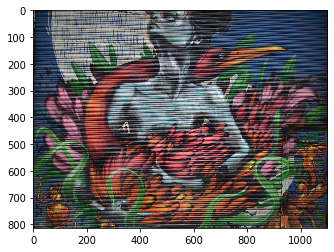

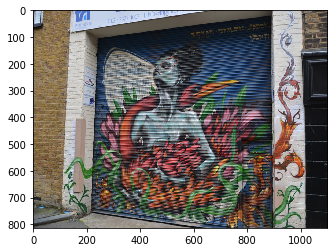

In [1]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import kornia as K
from kornia.color import rgb_to_grayscale
import kornia.feature as KF
from kornia.geometry.robust_estimators import find_homography_dlt_iterated
import numpy as np
import cv2
from PIL import Image
from time import time

def visualize_LAF(img, LAF, img_idx = 0):
    x, y = KF.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(K.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

device = torch.device('cpu')
#device = torch.device('cuda:0')


img1 = Image.open('data/matching/graffiti.png')
img2 = Image.open('data/matching/graffiti4.ppm')#.resize(img1.size)

img1 = Image.open('data/homography/v_birdwoman/1.ppm')
img2 = Image.open('data/homography/v_birdwoman/6.ppm').resize(img1.size)


timg1 = K.utils.image_to_tensor(np.array(img1), False).float() / 255.
timg2 = K.utils.image_to_tensor(np.array(img2), False).float() / 255.

timg = torch.cat([timg1,timg2], dim=0)

timg_gray = rgb_to_grayscale(timg)

plt.imshow(K.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(K.utils.tensor_to_image(timg[1]))


701 tentative correspondences found
501 inliers found


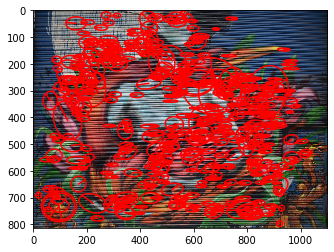

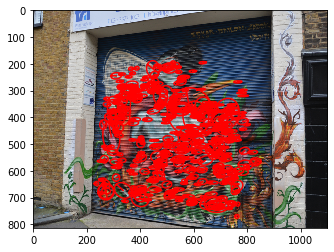

In [3]:
#Now lets define local deature detector and descriptor
PS = 32
detector = KF.ScaleSpaceDetector(4000,
                              resp_module=KF.BlobHessian(),
                              nms_module=K.geometry.ConvQuadInterp3d(10),
                              scale_pyr_module=K.geometry.ScalePyramid(3, 1.6, PS, double_image=False),
                              ori_module=KF.LAFOrienter(19),
                              aff_module=KF.LAFAffineShapeEstimator(19),
                              mr_size=6.0).to(device)

descriptor = KF.HardNet(True).to(device)
with torch.no_grad():
    lafs, resps = detector(timg_gray)
    patches =  KF.extract_patches_from_pyramid(timg_gray, lafs, 32).to(device)
    B, N, CH, H, W = patches.size()
    descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
    # Matching
    tentatives, scores = KF.match_smnn(descs[0], descs[1], 0.95)
    print (f"{tentatives.size(0)} tentative correspondences found")
    kps = KF.laf.get_laf_center(lafs)
    kps_tent1 = kps[0:1,tentatives[:,0]]
    kps_tent2 = kps[1:2,tentatives[:,1]]
    # Finding homography
    H = find_homography_dlt_iterated(kps_tent1, kps_tent2, 1-scores.view(1,-1))
    
# draw inliers
kps_tent1_reproj = K.transform_points(H,kps_tent1)
rep_error = (kps_tent1_reproj - kps_tent2).pow(2).sum(dim=-1)
mask = rep_error.detach() <= 3.0
print (f"{mask.int().sum().item()} inliers found")
for i in range(2):
    visualize_LAF(timg, lafs[:,tentatives[:,i]][:,mask.view(-1)], i)